# Определение перспективного тарифа для телеком-компании

### Описание проекта

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**План**

1) **Изучить общую информацию.** Ознакомиться с данными.

2) **Подготовка данных.**

    - Приведите данные к нужным типам;
    - Найдите и исправьте ошибки в данных, если они есть.
    - Поясните, какие ошибки вы нашли и как их исправили. В данных вы найдёте звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.
    - Посчитайте для каждого пользователя:
        1. Количество сделанных звонков и израсходованных минут разговора по месяцам;
        2. Количество отправленных сообщений по месяцам;
        3. Объем израсходованного интернет-трафика по месяцам;
        4. Помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).
    
3) **Проанализировать данные.**

    - Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.
    
4) **Проверить гипотезы.**

    - Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
    - Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
    - Пороговое значение alpha задайте самостоятельно.
    Поясните:
    как вы формулировали нулевую и альтернативную гипотезы;
    какой критерий использовали для проверки гипотез и почему.
    
5) **Сделать общий вывод.**

### Изучаем общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import datetime
import math

Откроем файлы и изучим их

In [2]:
data_calls = pd.read_csv("/datasets/calls.csv")
data_internet = pd.read_csv("/datasets/internet.csv", index_col=[0])
data_messages = pd.read_csv("/datasets/messages.csv")
data_tariffs = pd.read_csv("/datasets/tariffs.csv")
data_users = pd.read_csv("/datasets/users.csv")

In [3]:
dictionary_with_frames ={
    'calls': data_calls,
    'internet': data_internet,
    'messages': data_messages,
    'tariffs': data_tariffs,
    'users': data_users 
}

In [4]:
def get_stat(dict_of_frames):
    """Функция для агрегации данных о нескольких загруженных таблицах.
    Собирает следующею информацию: количество объектов(строк) в данных,
    количество null-значений и тип каждого столбца
    """
    def table(dataframe, name):
        """Функция отвечающая за создание промежуточных таблиц,
        собирая данные из конкретного переданного фрейма
        """
        columns = dataframe.columns
        count_of_rows = len(columns)
        total = dataframe.shape[0]
        
        part_total_table = pd.DataFrame(data =[[0] * 5] * count_of_rows, 
                                        columns = ['total',
                                                   'frame',
                                                   "columns",
                                                   "null_values",
                                                   "type"])
    
        part_total_table['total'] = [total] * count_of_rows
        part_total_table['frame'] = [name] * count_of_rows
        part_total_table['columns'] = columns
        
        for column in columns:
            curent_type = str(dataframe[column].dtype)
            count_of_null = dataframe[column].isnull().sum()
            part_total_table.loc[part_total_table['columns'] == column,'null_values'] = count_of_null
            part_total_table.loc[part_total_table['columns'] == column,'type'] = curent_type
        return part_total_table
        
    final_frame = pd.DataFrame(columns = ['total','frame',"columns","null_values","type"])
    
    for name,frame in dict_of_frames.items():
        part_of_table = table(frame,name)
        final_frame = final_frame.append(part_of_table)
        
    final_frame = final_frame.reset_index(drop = True)
    final_frame_grouped = final_frame.groupby(['total','frame',"columns"]).sum()
    
    return final_frame_grouped

In [5]:
get_stat(dictionary_with_frames)

null_values     type
total  frame    columns                                    
2      tariffs  mb_per_month_included            0    int64
                messages_included                0    int64
                minutes_included                 0    int64
                rub_monthly_fee                  0    int64
                rub_per_gb                       0    int64
                rub_per_message                  0    int64
                rub_per_minute                   0    int64
                tariff_name                      0   object
500    users    age                              0    int64
                churn_date                     462   object
                city                             0   object
                first_name                       0   object
                last_name                        0   object
                reg_date                         0   object
                tariff                           0   object
                user_id                          0    int64
123036 messages id                               0   object
                message_date                     0   object
                user_id                          0    int64
149396 internet id                               0   object
                mb_used                          0  float64
                session_date                     0   object
                user_id                          0    int64
202607 calls    call_date                        0   object
                duration                         0  float64
                id                               0   object
                user_id                          0    int64

### Подготовка данных и предобработка данных

**Предобработка информации о звонках**

In [6]:
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%dT%H:%M:%S')
data_calls['month'] = data_calls['call_date'].dt.month

In [7]:
data_calls['duration'] = np.ceil(data_calls['duration'])

In [8]:
data_internet['mb_used'].value_counts()

0.00      19598
335.91        9
447.30        9
197.56        9
199.11        8
          ...  
182.69        1
726.03        1
315.12        1
898.99        1
677.66        1
Name: mb_used, Length: 70003, dtype: int64

Нашел нулевые значения в *mb_used*. 19598 из 149396 значений оказались нулевыми, возможно, что пользователи действительно не выходили в интернет.

In [9]:
zeros_count = data_internet[data_internet['mb_used'] == 0]
len(zeros_count)

19598

In [10]:
data_internet['mb_used'].max()

1724.83

In [11]:
# np.ceil(data_internet['mb_used'] / 1024).value_counts()

In [12]:
# data_internet['mb_used'] = np.ceil((data_internet['mb_used'] * 10) / 1024)

Вот тут как раз то, о чём я говорил (домножил на 10 и стало больше похоже на правду).

In [13]:
# Комментарий ревьюера 2
data_internet

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


In [14]:
data_calls.head(15)

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12
5,1000_5,2018-11-02,0.0,1000,11
6,1000_6,2018-10-18,0.0,1000,10
7,1000_7,2018-08-22,19.0,1000,8
8,1000_8,2018-09-15,19.0,1000,9
9,1000_9,2018-08-15,0.0,1000,8


Заменил нулевые значения в столбце **duration** на 1. Поменял тип данных на datetime, добавил отдельный столбец с месяцем для удобного просмотра данных. Окурглил значения в столбце **duration** до целых для удобства анализа.

**Предобработка информации о пользователях**

In [15]:
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'], format='%Y-%m-%dT%H:%M:%S')
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y-%m-%dT%H:%M:%S')
data_users['churn_date'] = data_users['churn_date'].fillna(value = datetime.datetime.now())

In [16]:
data_users.sample(15)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
171,1171,47,2022-10-23 13:10:59.457444,Москва,Каролина,Иванова,2018-03-20,smart
259,1259,33,2022-10-23 13:10:59.457444,Санкт-Петербург,Эмилия,Третьякова,2018-11-04,ultra
122,1122,60,2022-10-23 13:10:59.457444,Воронеж,Иулиан,Булгаков,2018-11-07,ultra
194,1194,70,2022-10-23 13:10:59.457444,Москва,Егор,Наумов,2018-12-03,smart
141,1141,52,2022-10-23 13:10:59.457444,Москва,Клариса,Короткова,2018-12-02,smart
188,1188,41,2022-10-23 13:10:59.457444,Санкт-Петербург,Габриэль,Соколов,2018-02-04,smart
300,1300,40,2022-10-23 13:10:59.457444,Москва,Тихон,Азерников,2018-07-26,ultra
419,1419,19,2022-10-23 13:10:59.457444,Новороссийск,Эльмира,Яшина,2018-07-19,smart
298,1298,29,2022-10-23 13:10:59.457444,Новосибирск,Надежда,Чеснокова,2018-07-26,smart
245,1245,32,2022-10-23 13:10:59.457444,Москва,Маргарита,Коновалова,2018-09-10,ultra


Заменил значения даты на datetime, выделил столбец с месяцем и добавил в таблицу.

**Предобработка информации о сообщениях**

In [17]:
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%dT%H:%M:%S')
data_messages['month'] = data_messages['message_date'].dt.month

Заменил значения даты на datetime, выделил столбец с месяцем и добавил в таблицу.

**Предобработка информации об интернет-сессиях**

In [18]:
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%dT%H:%M:%S')
data_internet['month'] = data_internet['session_date'].dt.month

array([[<AxesSubplot:title={'center':'mb_used'}>,
        <AxesSubplot:title={'center':'session_date'}>],
       [<AxesSubplot:title={'center':'user_id'}>,
        <AxesSubplot:title={'center':'month'}>]], dtype=object)

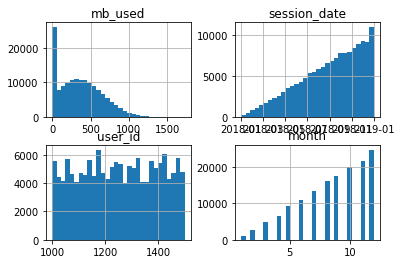

In [19]:
data_internet.hist(bins=30)

Здесь хочу заполнить пропуски в столбце *churn_date*

In [20]:
def fillna_churn_date(row):
    """Функция для генерации значений необходимых для
    заполнения пропущенных данных в столбце churn_date
    """
    if pd.isnull(row["churn_date"]):
        MAX_YEARS = 100
        delta = MAX_YEARS - row['age'] 
        date = str(2020 + delta)+'-08-26'
        row["churn_date"] = pd.to_datetime(date,format = '%Y-%m-%d')
    return row

In [21]:
data_users = data_users.apply(fillna_churn_date, axis = 1)

In [22]:
statistic_frame = pd.DataFrame(columns= ['user_id',
                                    "month",
                                    "count_calls",
                                    'calls_total_duration',
                                    'count_messages',
                                    'total_mb_used'
                                   ])
for idx in data_users['user_id']:
    for month_x in range(1,13):
        if ((month_x in data_calls.query('user_id == @idx')['month'].to_numpy()) or
            (month_x in data_messages.query('user_id == @idx')['month'].to_numpy())):
            
            count_calls = data_calls.query('user_id == @idx and month == @month_x').shape[0]
            total_duration_calls = data_calls.query('user_id == @idx and month == @month_x')['duration'].sum()
            count_messages = data_messages.query('user_id == @idx and month == @month_x').shape[0]
            total_used = data_internet.query('user_id == @idx and month == @month_x')['mb_used'].sum()
            
            statistic_frame = statistic_frame.append({'user_id':idx,
                               'month':month_x,             
                               "count_calls":count_calls,
                               'calls_total_duration':total_duration_calls,
                               'count_messages':count_messages,
                               'total_mb_used':total_used             
                                           }, ignore_index=True)

In [23]:
statistic_frame['user_id'] = statistic_frame['user_id'].astype('int')

In [24]:
statistic_frame = statistic_frame.merge(data_users[['user_id','tariff']], on = 'user_id')
statistic_frame = statistic_frame.merge(data_users[['user_id','city']], on = 'user_id')

In [25]:
def get_income(row):
    """Функция рассчитывающая доход копании с конкретного абонента
    """
    def get_extra(dict_of_param):
        """ Функция рассчитывающая минуты, потраченные абонентом сверх
        базового пакета
        """
        local_extra_min = 0
        local_extra_sms = 0
        local_extra_gb = 0
        if row['calls_total_duration'] > dict_of_param['calls_total_duration']: 
            local_extra_min = row['calls_total_duration'] - dict_of_param['calls_total_duration']
        if row['count_messages'] > dict_of_param['count_messages']:
            local_extra_sms = row['count_messages'] - dict_of_param['count_messages']
        if row['total_mb_used'] > dict_of_param['total_mb_used']:
            local_extra_gb = (row['total_mb_used'] - dict_of_param['total_mb_used'])/1024
        return local_extra_min, local_extra_sms, local_extra_gb   
    
    ultra_param = {
        'calls_total_duration':3000,
        'count_messages': 1000,
        'total_mb_used': 30 * 1024
    }
    smart_param = {
        'calls_total_duration':500,
        'count_messages': 50,
        'total_mb_used': 15 * 1024
    }
            
    if row['tariff'] == 'ultra':
        income = 1950
        extra_min, extra_sms, extra_gb = get_extra(ultra_param)
        income += extra_min + extra_sms + extra_gb * 150     
    elif row['tariff'] == 'smart':
        income = 550
        extra_min, extra_sms, extra_gb = get_extra(smart_param)
        income += 3 * extra_min + 3* extra_sms + extra_gb * 200 
    return income

In [26]:
statistic_frame['income'] = statistic_frame.apply(get_income, axis = 1)

In [27]:
statistic_frame

,user_id,month,count_calls,calls_total_duration,count_messages,total_mb_used,tariff,city,income
0,1000,5.0,22.0,159.0,22.0,2253.49,ultra,Краснодар,1950.000000
1,1000,6.0,43.0,172.0,60.0,23233.77,ultra,Краснодар,1950.000000
2,1000,7.0,47.0,340.0,75.0,14003.64,ultra,Краснодар,1950.000000
3,1000,8.0,52.0,408.0,81.0,14055.93,ultra,Краснодар,1950.000000
4,1000,9.0,58.0,466.0,57.0,14568.91,ultra,Краснодар,1950.000000
...,...,...,...,...,...,...,...,...,...
3208,1498,10.0,41.0,247.0,42.0,20579.36,smart,Владикавказ,1569.406250
3209,1499,9.0,9.0,70.0,11.0,1845.75,smart,Пермь,550.000000
3210,1499,10.0,68.0,449.0,48.0,17788.51,smart,Пермь,1024.318359
3211,1499,11.0,74.0,612.0,59.0,17963.31,smart,Пермь,1421.458984


Составим итоговую сводную таблицу

In [28]:
statistic_frame.pivot_table(index = 'tariff', values = ['calls_total_duration',
                                                        'count_messages',
                                                        'total_mb_used','income'], aggfunc = ["median",
                                                                                     "mean",
                                                                                     'var',
                                                                                     'std'])

median                                            \
       calls_total_duration count_messages       income total_mb_used   
tariff                                                                  
smart                 422.0           28.0   957.978516      16506.84   
ultra                 518.5           38.0  1950.000000      19311.93   

                       mean                                            \
       calls_total_duration count_messages       income total_mb_used   
tariff                                                                  
smart            417.934948      33.384029  1230.442346  16208.386990   
ultra            527.158537      49.413618  2059.980573  19488.051169   

                        var                                              \
       calls_total_duration count_messages         income total_mb_used   
tariff                                                                    
smart          36219.315784     796.812958  617357.200499  3.446250e+07   
ultra         100693.836489    2285.109519  126056.200780  1.014893e+08   

                        std                                           
       calls_total_duration count_messages      income total_mb_used  
tariff                                                                
smart            190.313730      28.227876  785.720816   5870.476681  
ultra            317.322921      47.802819  355.043942  10074.189914

Здесь я поравил вывод всей итоговой сводной таблицы

In [34]:
statistic_frame

,user_id,month,count_calls,calls_total_duration,count_messages,total_mb_used,tariff,city,income
0,1000,5.0,22.0,159.0,22.0,2253.49,ultra,Краснодар,1950.000000
1,1000,6.0,43.0,172.0,60.0,23233.77,ultra,Краснодар,1950.000000
2,1000,7.0,47.0,340.0,75.0,14003.64,ultra,Краснодар,1950.000000
3,1000,8.0,52.0,408.0,81.0,14055.93,ultra,Краснодар,1950.000000
4,1000,9.0,58.0,466.0,57.0,14568.91,ultra,Краснодар,1950.000000
...,...,...,...,...,...,...,...,...,...
3208,1498,10.0,41.0,247.0,42.0,20579.36,smart,Владикавказ,1569.406250
3209,1499,9.0,9.0,70.0,11.0,1845.75,smart,Пермь,550.000000
3210,1499,10.0,68.0,449.0,48.0,17788.51,smart,Пермь,1024.318359
3211,1499,11.0,74.0,612.0,59.0,17963.31,smart,Пермь,1421.458984


In [35]:
statistic_frame['total_mb_used'] = np.ceil(statistic_frame['total_mb_used'] / 1024)

**Вывод:** как видно из таблицы *statistic_frame*:

- Наибольший общий доход приносит тариф smart (общий и дополнительный);
- По столбцу **income** видим, что больше всего прибыльность имеет этот столбец.

### Построим гистограммы для пользователей *Smart* и *Ultra* тарифа

Гистрограмма для количества минут (добавил сюда же Ultra тариф, чтобы было более информативно).

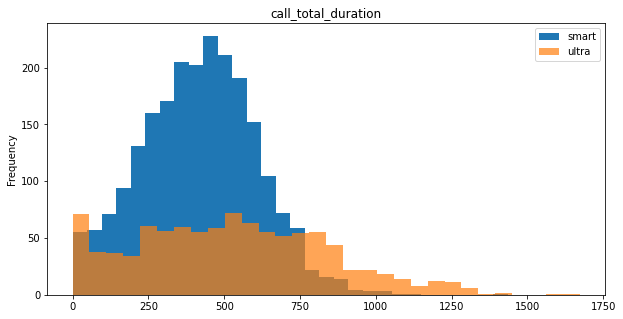

In [38]:
statistic_frame.loc[statistic_frame.loc[:,'tariff'] == 'smart']['calls_total_duration'].plot(
                                                                            kind = 'hist',
                                                                            bins = 30,
                                                                            label = 'smart', figsize = (10,5)
                                                                           )
statistic_frame.loc[statistic_frame.loc[:,'tariff'] == "ultra"]['calls_total_duration'].plot(
                                                                            kind = 'hist',
                                                                            bins = 30,
                                                                            alpha =0.7,
                                                                            label = 'ultra',figsize = (10,5)
                                                                           )
plt.title('call_total_duration')
plt.legend()
plt.show()

Исходя из графика, сделаем вывод, что основной пик приходится на интервал между 250 и 750. Достаточно большое количество людей переходят за рубеж 500 минут, видно, что данная тенденция свойственна как для пользователей Smart тарифа, так и для пользователей Ultra тарифа.

Гистрограмма для количества сообщений

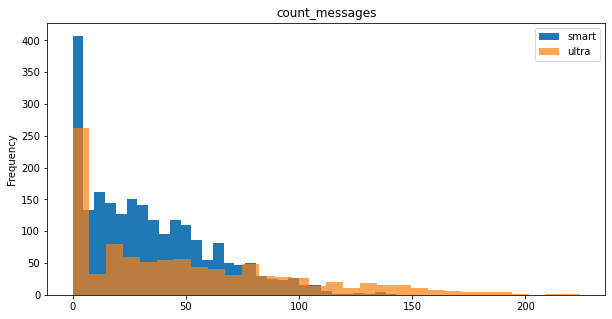

In [39]:
statistic_frame.loc[statistic_frame.loc[:,'tariff'] == 'smart']['count_messages'].plot(
                                                                            kind = 'hist',
                                                                            bins = 30,
                                                                            label = 'smart', figsize = (10,5)
                                                                           )
statistic_frame.loc[statistic_frame.loc[:,'tariff'] == "ultra"]['count_messages'].plot(
                                                                            kind = 'hist',
                                                                            bins = 30,
                                                                            alpha =0.7,
                                                                            label = 'ultra',figsize = (10,5)
                                                                           )
plt.title('count_messages')
plt.legend()
plt.show()

Исходя из графика, сделаем вывод, что достаточно большое количество людей не отправляют сообщения. Несмотря на лимит в 50 сообщений, достаточное количество людей превышают данный лимит. Число отправлявших сообщение пользоватейлей тарифа Ultra больше, чем пользователей тарифа Smart

Гистрограмма для количества потраченного трафика интернета

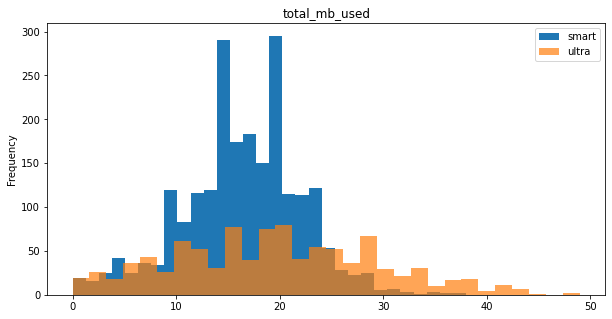

In [40]:
statistic_frame.loc[statistic_frame.loc[:,'tariff'] == 'smart']['total_mb_used'].plot(
                                                                            kind = 'hist',
                                                                            bins = 30,
                                                                            label = 'smart', figsize = (10,5)
                                                                           )
statistic_frame.loc[statistic_frame.loc[:,'tariff'] == "ultra"]['total_mb_used'].plot(
                                                                            kind = 'hist',
                                                                            bins = 30,
                                                                            alpha =0.7,
                                                                            label = 'ultra',figsize = (10,5)
                                                                           )
plt.title('total_mb_used')
plt.legend()
plt.show()

Исходя из графика, сделаем вывод, что подавляющая часть людей приходится на пик в 15Гб, полный трафик интернета тратит малое количество людей (тенденция к снижению ближе к 40Гб) и лишь небольшая часть людей не превышает границу в 5Гб. Пик использования интернет трафика у пользователей смарт приходится на 20Гб.

Построим графики по выручке

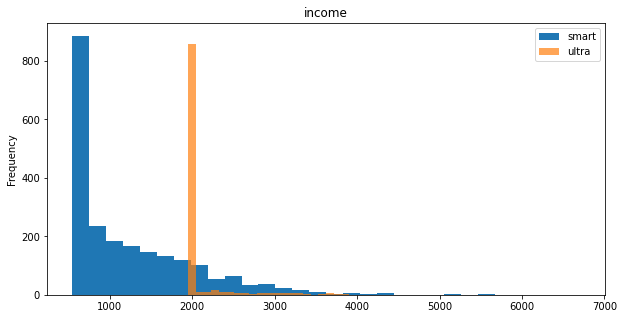

In [41]:
statistic_frame.loc[statistic_frame.loc[:,'tariff'] == 'smart']['income'].plot(
                                                                            kind = 'hist',
                                                                            bins = 30,
                                                                            label = 'smart', figsize = (10,5)
                                                                           )
statistic_frame.loc[statistic_frame.loc[:,'tariff'] == "ultra"]['income'].plot(
                                                                            kind = 'hist',
                                                                            bins = 30,
                                                                            alpha =0.7,
                                                                            label = 'ultra',figsize = (10,5)
                                                                           )
plt.title('income')
plt.legend()
plt.show()

Пользователи тарифа Ultra не тратят весь базовый пакет в отличие от пользователей тарифа Smart

In [49]:
statistic_frame.pivot_table(index = 'tariff', values = ['calls_total_duration', 'count_messages', 'total_mb_used', 'income'], aggfunc = "mean")

,calls_total_duration,count_messages,income,total_mb_used
tariff,,,,
smart,417.934948,33.384029,1230.442346,16.328847
ultra,527.158537,49.413618,2059.980573,19.513211


**Вывод:** как видим из распределений:

- Поведение пользователей *Smart* и *Ultra* различаются: одни не укладываются в лимит (по разговорным минутам и мегабайтам), а вторые зачастую выходят за рамки лимита (по мегабайтам);
- Распределения имеют схожие параметры (особенно колиечство потраченного трафика интернета). Количество сообщений отправляет мало людей, что в одном тарифе, что в другом, по лимитам минут звонков в тарифе ультра пользователи зачастую не укладываются.

### Проверим гипотезы

**Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются**

В данном случае нулевая гипотеза H₀ - средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается (то есть сохраняем равенство). В случае, если средняя выручка различается, формулируется альтернативная гипотеза H₁. Уровень критической значимости выставим равным 0.05

In [50]:
income_ultra = statistic_frame.loc[statistic_frame.loc[:,'tariff'] == 'ultra']['income']
income_smart = statistic_frame.loc[statistic_frame.loc[:,'tariff'] == 'smart']['income']

print('cреднее Smart: ',pd.Series(income_smart).mean())
print('cреднее Ultra: ',pd.Series(income_ultra).mean())
alpha = .05

results = st.ttest_ind(
    income_smart, 
    income_ultra)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Нулевую гипотезу можно отвергнуть")
else:
    print("Нулевую гипотезу можно не отвергать")

cреднее Smart:  1230.4423455725662
cреднее Ultra:  2059.9805729563645
p-value: 2.682085848388443e-192
Нулевую гипотезу можно отвергнуть


p-value = 2.6, следовательно, гипотезу можно отвергнуть. По подсчётам видно, что в среднем пользователи тарифа *Ultra* приносят выручку больше, чем пользователи тарифа *Smart*. Но стоит также учесть, что гипотезу мы выдвинули одностороннюю.

**Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов**

In [51]:
city_moscow = statistic_frame.loc[statistic_frame.loc[:,'city'] == 'Москва']['income']
city_other = statistic_frame.loc[statistic_frame.loc[:,'city'] != 'Москва']['income']

In [52]:
print('cреднее по Москве: ',pd.Series(city_moscow).mean())
print('cреднее по другим городам: ',pd.Series(city_other).mean())
alpha = .05

results = st.ttest_ind(
    city_moscow, 
    city_other)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Нулевую гипотезу можно отвергнуть")
else:
    print("Нулевую гипотезу можно не отвергать")

cреднее по Москве:  1504.5133500896516
cреднее по другим городам:  1479.801662894977
p-value: 0.48300460613857454
Нулевую гипотезу можно не отвергать


Видим, что средняя выручка по Москве и другим городам не сильно отличается. p-value = 0.4 (то бишь входит в диапазон статистической значимости), следовательно, мы можем не отвергать нулевую гипотезу.

### Общий вывод

Кратко по основам:
- Провёл первичное исследование данных;
- Провёл предобработку данных, заполнил пропуски. Заменил данные на более удобный формат для дальнейшего анализа, заменил нулевые значения.
- Провёл исследовательский анализ и, построив диаграммы, заметил несколько особенностей:
    1) Поведение пользователей Smart и Ultra различаются: одни не укладываются в лимит (по разговорным минутам и мегабайтам), а вторые зачастую выходят за рамки лимита (по мегабайтам);
    2) Распределения имеют схожие параметры (особенно колиечство потраченного трафика интернета). Количество сообщений отправляет мало людей, что в одном тарифе, что в другом, по лимитам минут звонков в тарифе ультра пользователи зачастую не укладываются.
- После проведения тестов сделал выводы о том, что:
  различие в средней выручке между Москвой и регионами незначительная, средняя выручка у тарифа Ultra выше, но больше прибыли приносит тариф Smart.